In [1]:
import csv
import collections

import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt

%matplotlib inline

## Read entrez gene

In [2]:
# read entrez genes
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/6e133f9ef8ce51a4c5387e58a6cc97564a66cec8/data/genes-human.tsv'
entrez_df = pandas.read_table(url, dtype={'GeneID': str})
human_genes = set(entrez_df.GeneID)
human_coding_genes = set(entrez_df[entrez_df.type_of_gene == 'protein-coding'].GeneID)

## GMT functions

In [3]:
def read_gmt(path):
    read_file = open(path)
    reader = csv.reader(read_file, delimiter='\t')
    for row in reader:
        name = row[0]
        description = row[1]
        genes = set(row[2:])
        yield name, description, genes
    read_file.close()

## Resource downloads

In [4]:
%%capture

# download wikipathways
url = 'http://www.pathvisio.org/data/bots/gmt/wikipathways.gmt'
! wget --timestamping --directory-prefix=download $url

# download MSigDB 5.0 pathways
url = 'https://www.broadinstitute.org/gsea/resources/msigdb/5.0/c2.cp.v5.0.entrez.gmt'
! wget --timestamping --directory-prefix=download $url

## Parse WikiPathways

In [5]:
gmt_generator = read_gmt('download/wikipathways.gmt')
wikipath_df = pandas.DataFrame(gmt_generator, columns = ['name', 'description', 'genes'])
len(wikipath_df)

1142

In [6]:
# Remove genes absent from our entrez gene version
for genes in wikipath_df.genes:
    genes &= human_genes
wikipath_df = wikipath_df[wikipath_df.genes.map(bool)]
len(wikipath_df)

290

In [7]:
wikipath_df.head()

,name,description,genes
152,Tryptophan metabolism(Homo sapiens),http://wikipathways.org/instance/WP465,"set([1572, 1573, 8854, 23498, 130013, 217, 154..."
153,Steroid Biosynthesis(Homo sapiens),http://wikipathways.org/instance/WP496,"set([3292, 3283, 3293, 51478, 1369, 3294, 3295..."
154,Arylamine metabolism(Homo sapiens),http://wikipathways.org/instance/WP694,"set([9, 10, 54600, 6799, 1544, 54657, 6817])"
155,Regulation of Actin Cytoskeleton(Homo sapiens),http://wikipathways.org/instance/WP51,"set([1956, 8503, 50649, 1132, 2147, 10163, 529..."
156,Interleukin-11 Signaling Pathway(Homo sapiens),http://wikipathways.org/instance/WP2332,"set([3716, 2534, 3717, 2242, 5296, 10401, 3589..."


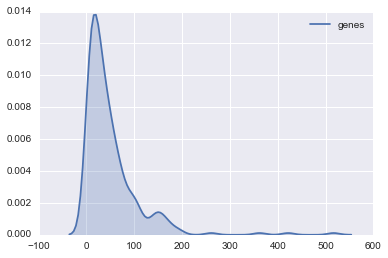

In [8]:
# Density plot of genes per pathway
seaborn.kdeplot(wikipath_df.genes.map(len), shade=True, );

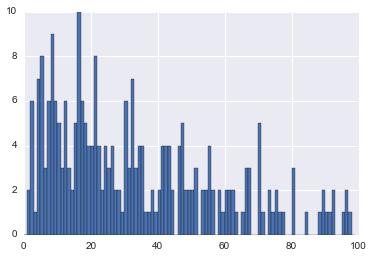

In [9]:
# Histogram of genes per pathway
plt.hist(list(wikipath_df.genes.map(len)), numpy.arange(100));
plt.xlim(0, 100);

## Parse MSigDB Pathways

In [10]:
gmt_generator = read_gmt('download/c2.cp.v5.0.entrez.gmt')
msigdb_df = pandas.DataFrame(gmt_generator, columns = ['name', 'description', 'genes'])
len(msigdb_df)

1330

In [11]:
# Remove genes absent from our entrez gene version
for genes in msigdb_df.genes:
    genes &= human_genes
msigdb_df = msigdb_df[msigdb_df.genes.map(bool)]
len(msigdb_df)

1330

In [12]:
msigdb_df.head()

,name,description,genes
0,KEGG_GLYCOLYSIS_GLUCONEOGENESIS,http://www.broadinstitute.org/gsea/msigdb/card...,"set([55902, 5315, 5223, 92483, 5214, 130589, 4..."
1,KEGG_CITRATE_CYCLE_TCA_CYCLE,http://www.broadinstitute.org/gsea/msigdb/card...,"set([47, 3420, 5161, 1737, 1743, 5091, 6390, 3..."
2,KEGG_PENTOSE_PHOSPHATE_PATHWAY,http://www.broadinstitute.org/gsea/msigdb/card...,"set([5214, 229, 2203, 2821, 84076, 6888, 7086,..."
3,KEGG_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS,http://www.broadinstitute.org/gsea/msigdb/card...,"set([231, 7367, 7358, 27294, 54579, 7366, 5457..."
4,KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM,http://www.broadinstitute.org/gsea/msigdb/card...,"set([231, 5214, 9108, 229, 5207, 2203, 3099, 5..."


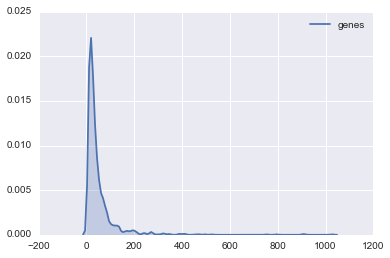

In [13]:
# Density plot of genes per pathway
seaborn.kdeplot(msigdb_df.genes.map(len), shade=True);

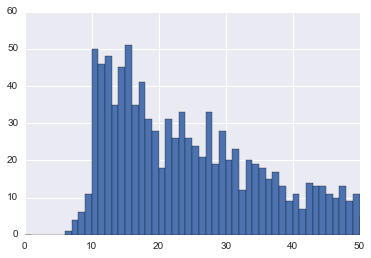

In [14]:
# Histogram of genes per pathway
plt.hist(msigdb_df.genes.map(len), numpy.arange(100));
plt.xlim(0, 50);

In [15]:
# MSigDB pathways per source database
# https://www.broadinstitute.org/gsea/msigdb/collection_details.jsp#CP
collections.Counter(msigdb_df.name.map(lambda x: x.split('_', 1)[0]))

Counter({'REACTOME': 674, 'BIOCARTA': 217, 'PID': 196, 'KEGG': 186, 'ST': 28, 'SA': 10, 'NABA': 10, 'SIG': 8, 'WNT': 1})

## Merge resources into a pathway dataframe

In [16]:
pathway_df = pandas.concat([
    pandas.DataFrame({
        'identifier': msigdb_df['name'],
        'name': msigdb_df['name'],
        'url': msigdb_df['description'],
        'source': 'msigdb',
        'genes': msigdb_df.genes}),

    pandas.DataFrame({
        'identifier': wikipath_df['description'].map(lambda x: x.rsplit('/', 1)[1]),
        'name': wikipath_df['name'],
        'url': wikipath_df['description'],
        'source': 'wikipathways',
        'genes': wikipath_df.genes
    })
])[['identifier', 'name', 'url', 'source', 'genes']]
len(pathway_df)

1620

In [17]:
# Remove duplicate pathways
pathway_df.genes = pathway_df.genes.map(frozenset)
pathway_df = pathway_df.drop_duplicates(['genes'])
len(pathway_df)

1619

In [18]:
pathway_df['coding_genes'] = pathway_df.genes.map(lambda x: x & human_coding_genes)

In [19]:
pathway_df.insert(3, 'n_genes', pathway_df.genes.map(len))
pathway_df.insert(4, 'n_coding_genes', pathway_df.coding_genes.map(len)) 

In [20]:
pathway_df.head()

,identifier,name,url,n_genes,n_coding_genes,source,genes,coding_genes
0,KEGG_GLYCOLYSIS_GLUCONEOGENESIS,KEGG_GLYCOLYSIS_GLUCONEOGENESIS,http://www.broadinstitute.org/gsea/msigdb/card...,62,62,msigdb,"(55902, 5315, 5223, 92483, 5214, 130589, 44153...","(55902, 5315, 5223, 92483, 5214, 130589, 44153..."
1,KEGG_CITRATE_CYCLE_TCA_CYCLE,KEGG_CITRATE_CYCLE_TCA_CYCLE,http://www.broadinstitute.org/gsea/msigdb/card...,32,30,msigdb,"(47, 3420, 5161, 1737, 1743, 5091, 6390, 3421,...","(47, 3420, 5161, 1737, 1743, 5091, 6390, 3421,..."
2,KEGG_PENTOSE_PHOSPHATE_PATHWAY,KEGG_PENTOSE_PHOSPHATE_PATHWAY,http://www.broadinstitute.org/gsea/msigdb/card...,27,27,msigdb,"(5236, 226, 5214, 229, 55276, 8789, 2203, 2821...","(5214, 229, 2203, 2821, 84076, 6888, 7086, 522..."
3,KEGG_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS,KEGG_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS,http://www.broadinstitute.org/gsea/msigdb/card...,28,28,msigdb,"(231, 7367, 7358, 27294, 54579, 9942, 7364, 73...","(231, 7367, 7358, 27294, 54579, 7366, 54578, 5..."
4,KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM,KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM,http://www.broadinstitute.org/gsea/msigdb/card...,34,34,msigdb,"(231, 5214, 9108, 229, 5207, 2203, 3099, 5208,...","(231, 5214, 9108, 229, 5207, 2203, 3099, 5208,..."


In [21]:
# Create a dataframe for writing as a tsv. Multi-element fields are pipe delimited.
write_df = pathway_df.copy()
join = lambda x: '|'.join(map(str, x))
for column in 'genes', 'coding_genes':
    write_df[column] = write_df[column].map(join)

write_df.to_csv('data/pathways.tsv', index=False, sep='\t')